# Machine Learning Explainability - Titanic example

In [ ]:
!pip install eli5
# pdpbox has some problems in their pypi version
!pip install git+https://github.com/SauceCat/PDPbox
!pip install shap

In [1]:
import pandas as pd
import eli5
import pdpbox
import shap

## Reading and preprocessing data

In [2]:
df = pd.read_csv('data/train.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
df = df[['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare']]
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
0,0,3,male,22.0,1,0,7.2500
1,1,1,female,38.0,1,0,71.2833
2,1,3,female,26.0,0,0,7.9250
3,1,1,female,35.0,1,0,53.1000
4,0,3,male,35.0,0,0,8.0500


In [4]:
X = df.drop('Survived', axis=1)
y = df.Survived

In [5]:
X['Age'] = X.Age.fillna(X.Age.mean())
X['Sex'] = X.Sex.apply(lambda sex: int(sex == 'female'))

## Fitting model

In [19]:
from sklearn.tree import DecisionTreeClassifier

In [20]:
model = DecisionTreeClassifier().fit(X, y)

## Permutation Importance

In [21]:
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(model, random_state=1).fit(X, y)
eli5.show_weights(perm, feature_names=X.columns.tolist())

Weight,Feature
0.2584 ± 0.0052,Sex
0.2135 ± 0.0160,Age
0.2047 ± 0.0134,Fare
0.1336 ± 0.0043,Pclass
0.0864 ± 0.0128,Parch
0.0431 ± 0.0084,SibSp


## Partial Dependence Plots

In [22]:
%matplotlib inline
from matplotlib import pyplot as plt
from pdpbox import pdp

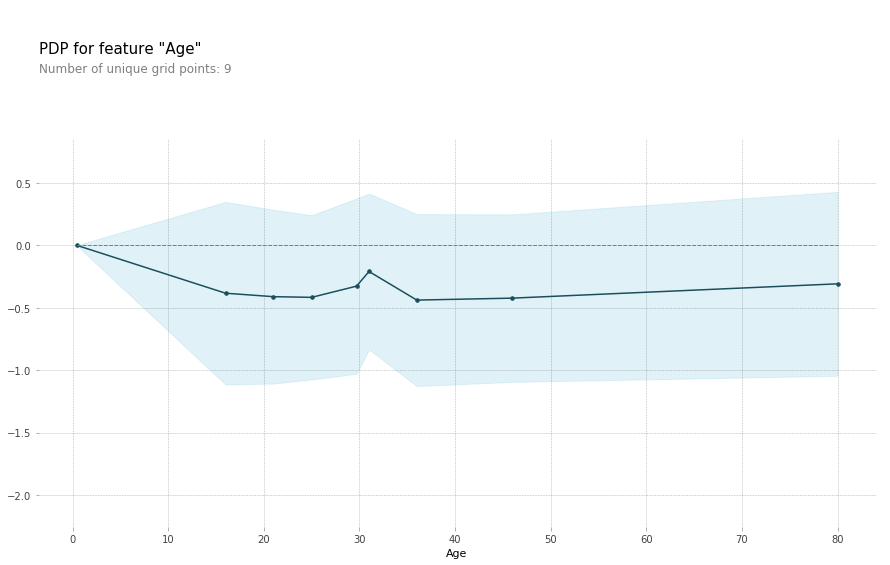

In [23]:
pdp_age = pdp.pdp_isolate(model=model, dataset=X, model_features=X.columns.tolist(), feature='Age')
pdp.pdp_plot(pdp_age, 'Age')
plt.show()

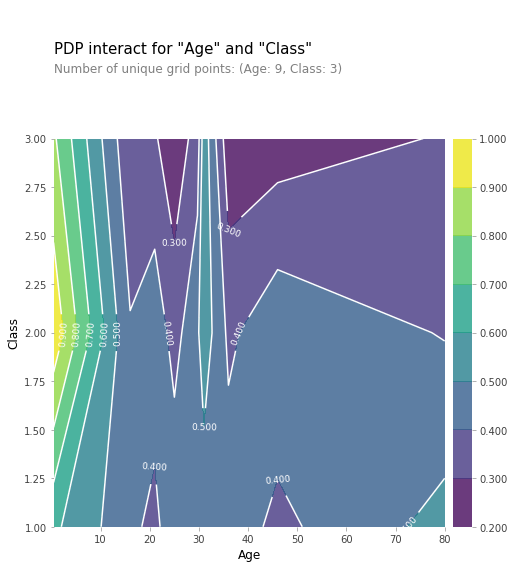

In [24]:
pdp_interaction = pdp.pdp_interact(model=model, dataset=X, model_features=X.columns.tolist(), features=['Age', 'Pclass'])
pdp.pdp_interact_plot(pdp_interact_out=pdp_interaction, feature_names=['Age', 'Class'], plot_type='contour')
plt.show()

## SHAP Values

In [25]:
specific_passenger = X[(X.Age == 30) & (X.Pclass == 3) & (X.Sex == 1)].iloc[[0]]

In [26]:
specific_passenger

,Pclass,Sex,Age,SibSp,Parch,Fare
79,3,1,30.0,0,0,12.475


In [28]:
explainer = shap.TreeExplainer(model, X)

shap_values = explainer.shap_values(specific_passenger)
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], specific_passenger)

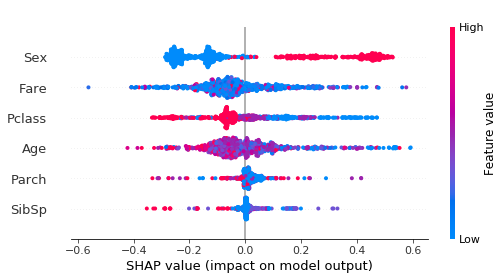

In [31]:
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values[1], X)

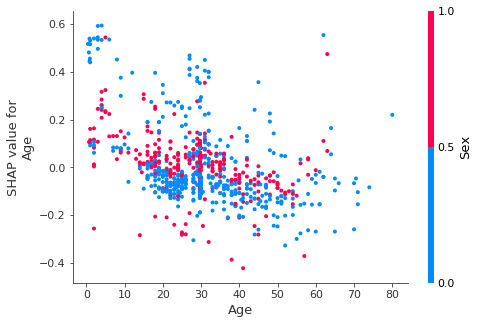

In [43]:
shap.dependence_plot('Age', shap_values[1], X, interaction_index="Sex")